# Generación de nodos

In [ ]:

import geopandas as gpd
import numpy as np
import osmnx as ox 
import matplotlib.pyplot as plt
import networkx as nx
import shapely
import geopy.distance
import os
import glob
import pandas as pd
import math
from pyproj import CRS


from shapely.geometry import Point
from sklearn.neighbors import BallTree
from libpysal import weights

In [ ]:


def cargar_datos_carpeta(ruta_carpeta):
    """
    Carga todos los archivos GeoJSON de una carpeta, combina los datos y elimina duplicados por 'osmid'.

    :param ruta_carpeta: Ruta a la carpeta que contiene los archivos GeoJSON.
    :return: GeoDataFrame combinado sin duplicados.
    """
    # Obtener la lista de archivos GeoJSON en la carpeta
    lista_archivos = glob.glob(os.path.join(ruta_carpeta, '*.geojson'))
    
    # Lista para almacenar los GeoDataFrames
    lista_gdfs = []
    
    # Cargar y combinar todos los archivos GeoJSON
    for archivo in lista_archivos:
        gdf = gpd.read_file(archivo)
        lista_gdfs.append(gdf)
    
    # Combinar todos los GeoDataFrames en uno solo
    if lista_gdfs:
        gdf_combined = pd.concat(lista_gdfs, ignore_index=True)
        # Eliminar puntos duplicados comparando por 'osmid'
        gdf_combined = gdf_combined.drop_duplicates(subset='osmid')
        return gdf_combined
    else:
        print(f"No se encontraron archivos GeoJSON en la carpeta: {ruta_carpeta}")
        return gpd.GeoDataFrame()  # Retorna un GeoDataFrame vacío si no hay archivos

def agregar_nodos_al_grafo(gdf, grafo, nombre_categoria):
    """
    Agrega nodos al grafo a partir de un GeoDataFrame y asigna una categoría a cada nodo.

    :param gdf: GeoDataFrame que contiene las geometrías y atributos.
    :param grafo: Grafo de NetworkX al que se agregarán los nodos.
    :param nombre_categoria: Nombre de la categoría a la que pertenecen los nodos.
    """
    for idx, row in gdf.iterrows():
        geom = row.geometry
        osmid = str(row['osmid'])
        
        if isinstance(geom, shapely.geometry.Point):
            x, y = geom.x, geom.y
        elif isinstance(geom, (shapely.geometry.Polygon, shapely.geometry.MultiPolygon)):
            centroide = geom.centroid
            x, y = centroide.x, centroide.y
        elif isinstance(geom, shapely.geometry.LineString):
            punto_medio = geom.interpolate(0.5, normalized=True)
            x, y = punto_medio.x, punto_medio.y
        else:
            print(f"Geometría no soportada para osmid {osmid}: {type(geom)}")
            continue
        
        # Agregar o actualizar el nodo con la categoría
        if osmid in grafo.nodes:
            if 'categoria' in grafo.nodes[osmid]:
                grafo.nodes[osmid]['categoria'].add(nombre_categoria)
            else:
                grafo.nodes[osmid]['categoria'] = {nombre_categoria}
        else:
            grafo.add_node(osmid, pos=(x, y), categoria={nombre_categoria})

def agregar_aristas_entre_categorias(grafo, gdf_origen, gdf_destino):
    """
    Agrega aristas al grafo entre nodos de dos GeoDataFrames, calculando la distancia geodésica.

    :param grafo: Grafo de NetworkX al que se agregarán las aristas.
    :param gdf_origen: GeoDataFrame de nodos de origen.
    :param gdf_destino: GeoDataFrame de nodos de destino.
    """
    for idx_origen, row_origen in gdf_origen.iterrows():
        osmid_origen = str(row_origen['osmid'])
        if osmid_origen not in grafo.nodes:
            continue  # Si el nodo no está en el grafo, saltar

        nodo_origen = grafo.nodes[osmid_origen]
        for idx_destino, row_destino in gdf_destino.iterrows():
            osmid_destino = str(row_destino['osmid'])
            if osmid_destino not in grafo.nodes:
                continue  # Si el nodo no está en el grafo, saltar

            nodo_destino = grafo.nodes[osmid_destino]
            distancia = geopy.distance.geodesic(nodo_origen['pos'], nodo_destino['pos']).km
            grafo.add_edge(osmid_origen, osmid_destino, weight=distancia)

def procesar_categorias(ruta_pivotes, rutas_categorias):
    """
    Procesa los datos de pivotes y categorías, y construye el grafo con nodos y aristas.

    :param ruta_pivotes: Ruta a la carpeta que contiene los archivos GeoJSON de los pivotes.
    :param rutas_categorias: Lista de rutas a las carpetas que contienen los archivos GeoJSON de las categorías.
    :return: Grafo dirigido con los nodos y aristas añadidos.
    """
    # Crear el grafo dirigido
    base_G = nx.DiGraph()
    
    # Cargar y procesar los pivotes
    pivots_H = cargar_datos_carpeta(ruta_pivotes)
    agregar_nodos_al_grafo(pivots_H, base_G, nombre_categoria='pivote')
    
    # Lista para almacenar los GeoDataFrames de las categorías
    lista_categorias = []
    
    # Cargar y procesar cada categoría
    for ruta_categoria in rutas_categorias:
        # Extraer el nombre de la categoría de la última carpeta en la ruta
        nombre_categoria = os.path.basename(os.path.normpath(ruta_categoria))
        categoria_gdf = cargar_datos_carpeta(ruta_categoria)
        if not categoria_gdf.empty:
            agregar_nodos_al_grafo(categoria_gdf, base_G, nombre_categoria=nombre_categoria)
            lista_categorias.append((nombre_categoria, categoria_gdf))
        else:
            print(f"No se pudo cargar datos para la categoría '{nombre_categoria}'")
    
    # Agregar aristas entre los pivotes y cada categoría
    for nombre_categoria, categoria_gdf in lista_categorias:
        agregar_aristas_entre_categorias(base_G, pivots_H, categoria_gdf)
    
    return base_G



def obtener_edgelist_con_categorias(grafo):
    """
    Convierte la lista de aristas del grafo en un DataFrame de pandas,
    incluyendo las categorías de los nodos origen y destino.

    :param grafo: Grafo de NetworkX.
    :return: DataFrame de pandas con las columnas:
             ['origen_osmid', 'categoria_origen', 'destino_osmid', 'categoria_destino', 'peso']
    """
    edgelist = []
    for origen, destino, data in grafo.edges(data=True):
        # Obtener categorías de los nodos origen y destino
        categoria_origen = ','.join(grafo.nodes[origen]['categoria'])
        categoria_destino = ','.join(grafo.nodes[destino]['categoria'])
        peso = data.get('weight', None)

        edgelist.append({
            'origen_osmid': origen,
            'categoria_origen': categoria_origen,
            'destino_osmid': destino,
            'categoria_destino': categoria_destino,
            'peso': peso
        })

    df_edgelist = pd.DataFrame(edgelist)
    return df_edgelist

In [ ]:
ruta_pivotes = r'Residentials'  # Reemplaza con la ruta real
# ruta_pivotes = r'Hotels'  # Reemplaza con la ruta real



rutas_categorias = [
    r'ShopsAndFood',
    r'Healthcare',
    r"CultureAndTourism",
    r"Education",
    r"FoodOnly",
    r"Public_transport",
    r"Security",
    r"ServicesAndGovernment"



    # Agrega más rutas de categorías según sea necesario
]

In [191]:
pivotes = cargar_datos_carpeta(ruta_pivotes)

In [192]:
grafo_resultante = procesar_categorias(ruta_pivotes, rutas_categorias)

# Filtro 1: Cantidad de servicios a 1 km

In [222]:
nx.write_edgelist(grafo_resultante, "grafo.edgelist")

In [195]:
min_weight = 1 # in KM

In [196]:
filtered_edges = [(u, v) for u, v, d in grafo_resultante.edges(data=True) if d['weight'] <= min_weight]
G_f1 = grafo_resultante.edge_subgraph(filtered_edges).copy()


In [197]:
# Obtener el edgelist con categorías
df_edgelist = obtener_edgelist_con_categorias(G_f1)

In [198]:
df_edgelist['categoria_destino'] = df_edgelist['categoria_destino'].str.split(",")


In [199]:
df_edgelist = df_edgelist.explode(['categoria_destino'])

In [223]:
df_edgelist.head(10)

,origen_osmid,categoria_origen,destino_osmid,categoria_destino,peso
0,3811555186,pivote,11191071020,FoodOnly,0.430085
0,3811555186,pivote,11191071020,ShopsAndFood,0.430085
1,3811555186,pivote,12073897250,FoodOnly,0.783599
1,3811555186,pivote,12073897250,ShopsAndFood,0.783599
2,3811555186,pivote,1098712221,FoodOnly,0.857259
2,3811555186,pivote,1098712221,ShopsAndFood,0.857259
3,3811555186,pivote,4949215123,FoodOnly,0.994307
3,3811555186,pivote,4949215123,ShopsAndFood,0.994307
4,3811555186,pivote,9163802072,FoodOnly,0.802640
4,3811555186,pivote,9163802072,ShopsAndFood,0.802640


In [201]:
df_metric_1 = df_edgelist.groupby(['origen_osmid','categoria_destino']).count()['destino_osmid'].reset_index()

df_metric_1.columns = ['osmid','categoria', 'metric_1']

In [202]:
df_metric_1['osmid'] = df_metric_1['osmid'].astype(str)

In [203]:
df_metric_1 = pd.pivot_table(df_metric_1, index = "osmid", columns = "categoria", values = "metric_1").reset_index()

In [204]:
columnaskeep = df_metric_1.columns

In [205]:
df_metric_1.head(10)

categoria,osmid,CultureAndTourism,Education,FoodOnly,Healthcare,Public_transport,Security,ServicesAndGovernment,ShopsAndFood,pivote
0,1004503203,181.0,43.0,242.0,57.0,80.0,342.0,136.0,327.0,NaN
1,1004503204,182.0,43.0,239.0,57.0,79.0,339.0,135.0,322.0,NaN
2,1004503207,166.0,42.0,232.0,56.0,69.0,211.0,99.0,318.0,NaN
3,1019784134,47.0,32.0,66.0,45.0,52.0,97.0,31.0,154.0,NaN
4,1019784135,48.0,32.0,63.0,43.0,51.0,95.0,31.0,150.0,NaN
5,1026813924,180.0,49.0,199.0,69.0,113.0,466.0,187.0,479.0,1.0
6,1031507928,109.0,63.0,123.0,32.0,30.0,23.0,30.0,169.0,NaN
7,1031507929,105.0,62.0,120.0,31.0,28.0,22.0,29.0,164.0,NaN
8,1040876696,177.0,68.0,313.0,79.0,50.0,137.0,83.0,337.0,NaN
9,1041407403,225.0,62.0,155.0,57.0,47.0,280.0,144.0,416.0,1.0


In [206]:
pivotes['osmid'] = pivotes['osmid'].astype(str)


In [207]:
df_metric_1 = pd.merge(df_metric_1, pivotes, on='osmid', how='outer').fillna("0")

In [209]:
df_metric_1.to_csv(r"C:\Users\Home\Desktop\Datathon2024\data_metricas_1_residentes.csv", sep = ";", index = False)

# Filtro 2: Distancia minima respecto a un punto

In [180]:
grafo_resultante

In [210]:
import os
import glob
import geopandas as gpd
import pandas as pd
import shapely.geometry
import networkx as nx
import geopy.distance
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import numpy as np

# Funciones proporcionadas anteriormente
def extraer_nodos_por_categoria(grafo):
    categorias = {}
    for node, data in grafo.nodes(data=True):
        pos = data['pos']
        categorias_node = data.get('categoria', [])
        point = Point(pos)
        for categoria in categorias_node:
            if categoria not in categorias:
                categorias[categoria] = []
            categorias[categoria].append({'osmid': node, 'geometry': point})
    categorias_gdf = {}
    for categoria, datos in categorias.items():
        categorias_gdf[categoria] = gpd.GeoDataFrame(datos, crs="EPSG:4326")
    return categorias_gdf

def construir_balltrees(categorias_gdf):
    balltrees = {}
    for categoria, gdf in categorias_gdf.items():
        coords_rad = np.radians(np.vstack((gdf.geometry.y, gdf.geometry.x)).T)
        tree = BallTree(coords_rad, metric='haversine')
        balltrees[categoria] = {
            'tree': tree,
            'gdf': gdf,
            'coords_rad': coords_rad
        }
    return balltrees

def encontrar_mas_cercano_por_categoria(pivots_gdf, balltrees):
    resultados = []
    pivots_coords_rad = np.radians(np.vstack((pivots_gdf.geometry.y, pivots_gdf.geometry.x)).T)
    for categoria_destino, tree_info in balltrees.items():
        if categoria_destino == 'pivote':
            continue  # Omitir los pivotes para evitar buscar vecinos entre ellos mismos
        tree = tree_info['tree']
        gdf_categoria = tree_info['gdf']
        dist, idx = tree.query(pivots_coords_rad, k=1)
        dist_km = dist.flatten() * 6371
        osmid_categoria = gdf_categoria.iloc[idx.flatten()]['osmid'].values
        osmid_pivotes = pivots_gdf['osmid'].values
        df_resultado = pd.DataFrame({
            'origen_osmid': osmid_pivotes,
            'categoria_origen': 'pivote',
            'destino_osmid': osmid_categoria,
            'categoria_destino': categoria_destino,
            'peso': dist_km
        })
        resultados.append(df_resultado)
    df_final = pd.concat(resultados, ignore_index=True)
    return df_final

def obtener_puntos_mas_cercanos(grafo):
    categorias_gdf = extraer_nodos_por_categoria(grafo)
    # Crear GeoDataFrame de los pivotes (hoteles)
    pivotes = []
    for node, data in grafo.nodes(data=True):
        if 'pivote' in data.get('categoria', []):
            pos = data['pos']
            pivotes.append({'osmid': node, 'geometry': Point(pos)})
    pivots_gdf = gpd.GeoDataFrame(pivotes, crs="EPSG:4326")
    balltrees = construir_balltrees(categorias_gdf)
    df_cercanos = encontrar_mas_cercano_por_categoria(pivots_gdf, balltrees)
    return df_cercanos

# Suponiendo que ya tienes el grafo_resultante creado con las funciones anteriores
# grafo_resultante = procesar_categorias(ruta_pivotes, rutas_categorias)

# Obtener el DataFrame en el formato deseado
df_puntos_cercanos = obtener_puntos_mas_cercanos(grafo_resultante)



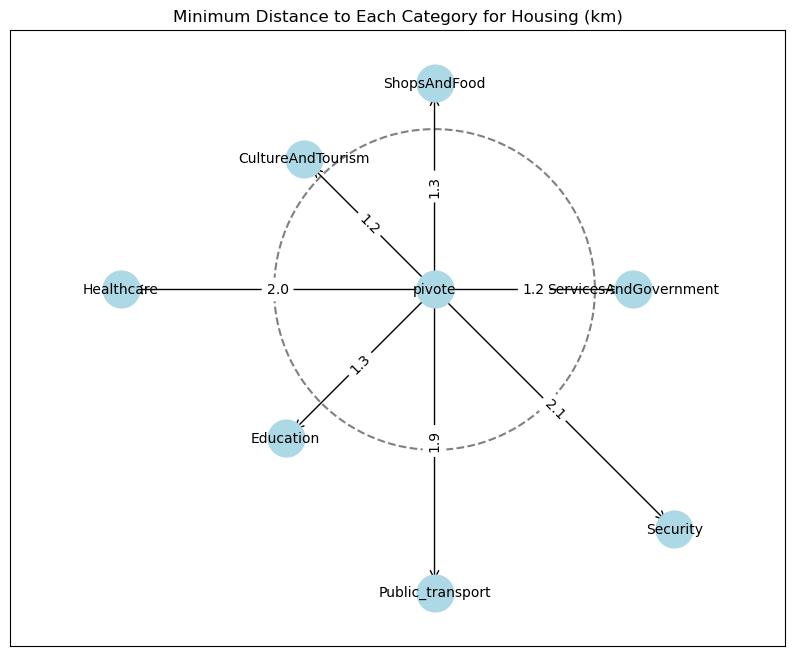

In [287]:
df_puntos_cercanos_punto = df_puntos_cercanos[df_puntos_cercanos["origen_osmid"]== "10977327"]
# Crear un grafo dirigido
G = nx.DiGraph()


# Agregar nodos y aristas al grafo con los pesos originales
for _, row in df_puntos_cercanos_punto.iterrows():
    origen = row['origen_osmid']
    destino = row['destino_osmid']
    peso = row['peso']
    categoria_origen = row['categoria_origen']
    categoria_destino = row['categoria_destino']
    
    # Agregar nodos con sus categorías
    G.add_node(origen, categoria=categoria_origen)
    G.add_node(destino, categoria=categoria_destino)
    
    # Agregar aristas con peso
    G.add_edge(origen, destino, weight=peso)

# Crear posiciones manuales en función del peso
pos = {}
center_node = list(df_puntos_cercanos_punto['origen_osmid'].unique())[0]  # Nodo central inicial
pos[center_node] = np.array([0, 0])  # Colocar el nodo inicial en el centro

# Obtener nodos conectados al centro y calcular su posición
angle_step = 2 * np.pi / len(df_puntos_cercanos_punto)  # Ángulo entre nodos

for i, (origen, destino, peso) in enumerate(zip(df_puntos_cercanos_punto['origen_osmid'], df_puntos_cercanos_punto['destino_osmid'], df_puntos_cercanos_punto['peso'])):
    # Calcular la distancia inversa del peso (1 / peso)
    distance = peso
    # Calcular el ángulo para distribuir en círculo
    angle = i * angle_step
    pos[destino] = pos[origen] + distance * np.array([np.cos(angle), np.sin(angle)])

# Dibujar el grafo
plt.figure(figsize=(10, 8))

# Dibujar el círculo punteado alrededor del nodo central
circle = plt.Circle(pos[center_node], 1, color='gray', linestyle='--', linewidth=1.5, fill=False)
plt.gca().add_patch(circle)

# Dibujar nodos y etiquetas de categorías
node_labels = nx.get_node_attributes(G, 'categoria')
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="black")

# Dibujar aristas y etiquetas de peso original
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15)
edge_labels = {edge: f"{G.edges[edge]['weight']:.1f}" for edge in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Minimum Distance to Each Category for Housing (km)")
plt.axis("equal")  # Para mantener la proporción del círculo
plt.show()

In [211]:
categorias = df_puntos_cercanos['categoria_destino'].drop_duplicates()
df_metric_2 = pd.pivot_table(df_puntos_cercanos, 
                             index = "origen_osmid", 
                             columns = "categoria_destino", 
                             values = "peso",
                             ).reset_index()

In [212]:
df_metrics = pd.merge(df_metric_1, 
                              df_metric_2, 
                              right_on='origen_osmid', 
                              left_on = "osmid",
                              how='outer',
                              suffixes = ("_Count", "_Min")
                              )

In [213]:
df_metrics

,osmid,CultureAndTourism_Count,Education_Count,FoodOnly_Count,Healthcare_Count,Public_transport_Count,Security_Count,ServicesAndGovernment_Count,ShopsAndFood_Count,pivote,...,opening_hours,origen_osmid,CultureAndTourism_Min,Education_Min,FoodOnly_Min,Healthcare_Min,Public_transport_Min,Security_Min,ServicesAndGovernment_Min,ShopsAndFood_Min
0,1004503203,181.0,43.0,242.0,57.0,80.0,342.0,136.0,327.0,0,...,0,1004503203,0.110932,0.501415,0.263516,0.288122,0.597692,0.245238,0.380770,0.263516
1,1004503204,182.0,43.0,239.0,57.0,79.0,339.0,135.0,322.0,0,...,0,1004503204,0.109384,0.493823,0.248459,0.284325,0.613255,0.246741,0.394468,0.248459
2,1004503207,166.0,42.0,232.0,56.0,69.0,211.0,99.0,318.0,0,...,0,1004503207,0.402766,0.254847,0.218197,0.306188,0.821167,0.166718,0.277339,0.195364
3,1019784134,47.0,32.0,66.0,45.0,52.0,97.0,31.0,154.0,0,...,0,1019784134,0.207539,0.895566,0.304638,0.670561,1.124539,0.623798,0.754382,0.304638
4,1019784135,48.0,32.0,63.0,43.0,51.0,95.0,31.0,150.0,0,...,0,1019784135,0.223544,0.898142,0.288283,0.639257,1.157734,0.659842,0.721126,0.288283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5811,999273115,178.0,37.0,458.0,58.0,38.0,178.0,78.0,519.0,0,...,0,999273115,0.165694,0.368862,0.319799,0.341669,0.451635,0.239295,0.361704,0.319799
5812,999736115,171.0,35.0,433.0,45.0,38.0,139.0,68.0,490.0,0,...,0,999736115,0.008825,0.422750,0.175125,0.557572,0.228223,0.184950,0.201404,0.175125
5813,999736117,170.0,35.0,452.0,52.0,39.0,149.0,70.0,511.0,0,...,0,999736117,0.060891,0.344939,0.261035,0.458800,0.312079,0.273535,0.295767,0.261035
5814,999736818,170.0,35.0,438.0,45.0,44.0,140.0,73.0,502.0,0,...,0,999736818,0.090355,0.253748,0.243612,0.436466,0.489242,0.264790,0.238569,0.243612


In [214]:
gdf_metrics = gpd.GeoDataFrame(df_metrics)

In [ ]:
gdf_metrics.to_file(rf"C:\Users\Home\Desktop\Datathon2024\metricas_{ruta_pivotes}.geojson")